In [1]:
!git clone https://github.com/Kartik-3004/facexformer.git

Cloning into 'facexformer'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 178 (delta 56), reused 38 (delta 38), pack-reused 116 (from 1)
Receiving objects: 100% (178/178), 19.74 MiB | 46.47 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [65]:
!python facexformer/inference.py \
--model_path /kaggle/working/ckpts/model.pt \
--image_path face.png \
--results_path . \
--task landmarks \
--gpu_num 0

/kaggle/working/facexformer/inference.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)
/usr/local/lib/python3

In [2]:
%%capture
!pip install git+https://github.com/thng292/facenet-pytorch.git
!pip install -r facexformer/requirements.txt

In [3]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="kartiknarayan/facexformer", filename="ckpts/model.pt", local_dir=".")

model.pt:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

'ckpts/model.pt'

In [4]:
!touch __init__.py

In [5]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import InterpolationMode
from math import cos, sin
from PIL import Image
from facexformer.network import FaceXFormer
from facenet_pytorch import MTCNN

In [6]:
# Load model
device = "cuda:0"
def load_model(weights_path):
    model = FaceXFormer().to(device)
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict_backbone'])
    model.eval()
    return model

In [57]:
# mtcnn = MTCNN(keep_all=True, device="cuda:1")
transforms_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224), interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def adjust_bbox(x_min, y_min, x_max, y_max, image_width, image_height, margin_percentage=50):
    width = x_max - x_min
    height = y_max - y_min
    
    increase_width = width * (margin_percentage / 100.0) / 2
    increase_height = height * (margin_percentage / 100.0) / 2
    
    x_min_adjusted = max(0, x_min - increase_width)
    y_min_adjusted = max(0, y_min - increase_height)
    x_max_adjusted = min(image_width, x_max + increase_width)
    y_max_adjusted = min(image_height, y_max + increase_height)
    
    return x_min_adjusted, y_min_adjusted, x_max_adjusted, y_max_adjusted


def cut_face(image, box):
    width, height = image.size
    # boxes, probs = mtcnn.detect(image)
    # if False or boxes is not None and len(boxes) == 1:
    #     x_min, y_min, x_max, y_max = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
    # else:
    x_min, y_min, x_max, y_max = box['left'], box['top'], box['left'] + box['width'], box['top'] + box['height']
    x_min, y_min, x_max, y_max = adjust_bbox(x_min, y_min, x_max, y_max, width, height)
    image = image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))
    image = transforms_image(image)
    return image, x_min, y_min

def cut_face_to_img(image, box):
    width, height = image.size
    # boxes, probs = mtcnn.detect(image)
    # if len(boxes) == 1:
    #     x_min, y_min, x_max, y_max = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
    # else:
    x_min, y_min, x_max, y_max = box['left'], box['top'], box['left'] + box['width'], box['top'] + box['height']
    x_min, y_min, x_max, y_max = adjust_bbox(x_min, y_min, x_max, y_max, width, height)
    image = image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))
    return image

In [8]:
def get_landmarks(model, face_image):
    task = torch.tensor([1]) # Landmark detection
    data = {'image': face_image, 'label': {"segmentation":torch.zeros([224,224]), "lnm_seg": torch.zeros([5, 2]),"landmark": torch.zeros([68, 2]), "headpose": torch.zeros([3]), "attribute": torch.zeros([40]), "a_g_e": torch.zeros([3]), 'visibility': torch.zeros([29])}, 'task': task}
    images, labels, tasks = data["image"], data["label"], data["task"]
    images = images.unsqueeze(0).to(device=device)
    for k in labels.keys():
        labels[k] = labels[k].unsqueeze(0).to(device=device)
    tasks = tasks.to(device=device)

    landmark_output, headpose_output, attribute_output, visibility_output, age_output, gender_output, race_output, seg_output = model(images, labels, tasks)
    return denorm_points(landmark_output.view(-1,68,2)[0],224,224)[0]

In [9]:
def denorm_points(points, h, w, align_corners=False):
    if align_corners:
        denorm_points = (points + 1) / 2 * torch.tensor([w - 1, h - 1], dtype=torch.float32).to(points).view(1, 1, 2)
    else:
        denorm_points = ((points + 1) * torch.tensor([w, h], dtype=torch.float32).to(points).view(1, 1, 2) - 1) / 2

    return denorm_points

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    tensor = tensor * std + mean 
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [10]:
# Copied from Claude
def calculate_nme(predicted_landmarks, ground_truth_landmarks, normalization_factor=None):
    """
    Calculate Normalized Mean Error (NME) between predicted and ground truth landmarks.
    
    Parameters:
    -----------
    predicted_landmarks : numpy.ndarray
        Array of shape (n_points, 2) containing predicted landmark coordinates (x, y).
    ground_truth_landmarks : numpy.ndarray
        Array of shape (n_points, 2) containing ground truth landmark coordinates (x, y).
    normalization_factor : float, optional
        Factor to normalize the error. If None, it will use the inter-ocular distance
        (distance between the eye centers) if the landmarks include eye positions,
        otherwise it will use the bounding box diagonal.
    
    Returns:
    --------
    float
        The Normalized Mean Error value.
    """
    # Check if inputs have the same shape
    if predicted_landmarks.shape != ground_truth_landmarks.shape:
        raise ValueError(f"Predicted and ground truth landmarks must have the same shape. Predicted shape: {predicted_landmarks.shape}, ground truth shape: {ground_truth_landmarks.shape}")
    
    # Calculate Euclidean distances between corresponding landmarks
    distances = np.sqrt(np.sum((predicted_landmarks - ground_truth_landmarks)**2, axis=1))
    
    # Calculate mean distance
    mean_error = np.mean(distances)
    
    # Determine normalization factor if not provided
    if normalization_factor is None:
        # If we have standard facial landmarks, use inter-ocular distance
        # Assuming landmarks[36:42] are left eye and landmarks[42:48] are right eye
        # This is based on the 68-point facial landmark configuration
        try:
            if ground_truth_landmarks.shape[0] >= 68:
                left_eye_center = np.mean(ground_truth_landmarks[36:42], axis=0)
                right_eye_center = np.mean(ground_truth_landmarks[42:48], axis=0)
                normalization_factor = np.linalg.norm(right_eye_center - left_eye_center)
            else:
                # Use bounding box diagonal if landmark format is unknown
                x_min, y_min = np.min(ground_truth_landmarks, axis=0)
                x_max, y_max = np.max(ground_truth_landmarks, axis=0)
                normalization_factor = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2)
        except:
            # Fallback to bounding box diagonal
            x_min, y_min = np.min(ground_truth_landmarks, axis=0)
            x_max, y_max = np.max(ground_truth_landmarks, axis=0)
            normalization_factor = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2)
    
    # Calculate NME
    nme = mean_error / normalization_factor
    
    return nme

In [11]:
import json
model_path = "/kaggle/working/ckpts/model.pt"
benchmark_base_path = "/kaggle/input/facial-lankmark-detection-benchmark"
benchmark_file_path = "/kaggle/input/facial-lankmark-detection-benchmark/dataset.json"

with open(benchmark_file_path) as f:
    benchmark = json.load(f)

model = load_model(model_path)

nmes = []
for row in benchmark:
    try:
        image = Image.open(os.path.join(benchmark_base_path, row["file"])).convert('RGB')
        face, x_min, y_min = cut_face(image, row["box"])
        predicted_landmarks = get_landmarks(model, face)
        denormed = predicted_landmarks.detach().cpu().numpy()
        for i in range(len(denormed)):
            denormed[i][0] += x_min
            denormed[i][1] += y_min
        nme = calculate_nme(denormed, np.array(row["landmarks"]))
        # break
    except:
        nme = np.nan
    nmes.append(nme)

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 203MB/s] 
<ipython-input-6-fe301d2918b2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

In [12]:
with open('facexformer.json', 'w') as f:
    json.dump(nmes, fp=f)

In [13]:
tmp = list(enumerate(nmes))
tmp.sort(key=lambda e: e[1], reverse=True)
tmp[:10]

[(193, 6.922165257600248),
 (41, 6.4964867312892896),
 (68, 6.42191841020984),
 (145, 6.19578352048676),
 (159, 6.0397538394816355),
 (75, 6.020415315216337),
 (186, 5.950835758282688),
 (27, 5.905352264453175),
 (45, 5.438658702508929),
 (188, 4.917045997509167)]

In [14]:
np.mean(nmes)

1.7947175462680114

In [63]:
cp /kaggle/input/facial-lankmark-detection-benchmark/ibug/image_091.jpg ./face.png

In [90]:
i = 20
row = benchmark[i]
image = Image.open(os.path.join(benchmark_base_path, row["file"])).convert('RGB')
face, x_min, y_min = cut_face(image, row["box"])
predicted_landmarks = get_landmarks(model, face)
# denormed = denorm_points(predicted_landmarks.view(-1,68,2)[0],224,224)
denormed = predicted_landmarks.detach().cpu().numpy()
for index in range(len(denormed)):
    denormed[index][0] += x_min
    denormed[index][1] += y_min

# print("face     ", face)
print("predicted", predicted_landmarks[:5])
print("ground tr", row["landmarks"][:5])
print("denormed ", denormed[0][:5])
nme = calculate_nme(denormed, np.array(row["landmarks"]))
print(nme)

predicted tensor([[ 70.8479,  71.4587],
        [ 76.9734,  87.9982],
        [ 77.5623, 101.1442],
        [ 76.9691, 116.9876],
        [ 79.5269, 133.7201]], device='cuda:0', grad_fn=<SliceBackward0>)
ground tr [[375, 239], [379, 262], [390, 276], [399, 294], [409, 309]]
denormed  [356.8479  198.45868]
0.7757291135141103


(224, 224)


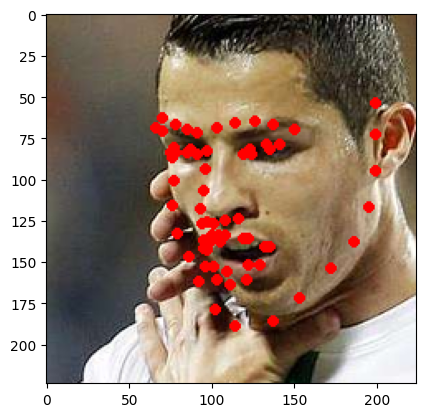

In [91]:
ff = cut_face_to_img(image, row["box"])
# ff = image
ff = ff.resize((224, 224), Image.Resampling.LANCZOS)
print(ff.size)
draw = ImageDraw.Draw(ff)

for x, y in predicted_landmarks:
    draw.ellipse((x - 3, y - 3, x + 3, y + 3), fill='red')

# draw.ellipse((-3,-3,3,3), fill='red')

plt.imshow(ff)
# plt.axis('off')  # Turn off axis labels and ticks
plt.show()